# Visual introduction to logistic regression (incomplete!)


## Introduction

Logistic regression is the loyal work horse of many statistical modelling tasks. It is used to estimate the probability of class memebership. That is, given an observation we would like to calcualte what is the probability of it belonging to certain pre-defined class. in this post we will look into what this means on an intuituve level. We will forget most of the math for now and descibe the problem setting and solution visually.

The name 'logistic regression' is somewhat ambigious: usually logistic regression is used in classification problems to fix observation into some class. Due to this reason logistic regression is often counted as a classifier rather than regressor. However, as explained in this <a href="https://stats.stackexchange.com/questions/127042/why-isnt-logistic-regression-called-logistic-classification">answer</a>, the name is in fact correct as logistic regression is used to regress the probability (continuous variable) of class membership, and it becames a classifier only when coupled with a decision rule based on the estimated probabilities.

In this post we will focus on a simple binary class case. That is, we assume that there are two target classes and it is our job to determine the probabilities of a given observation in belonging to either class. We will also see how to use the logistic regression as classifier when using a decision rule.

 

### Helper functions and libraries for the analysis

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display_html
from IPython.display import display
#%matplotlib notebook
%matplotlib inline

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline; border:0px"')          
    display_html(html_str,raw=True)

def plot_decision_boundaries(X, y, model, title = None, mesh_step_size = 0.1, correction = 1, featured = 0 , style = 'normal'):

    x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
    y_min, y_max = X[:, 1].min() - correction, X[:, 1].max() + correction
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Colors    
    cmap = plt.cm.PuOr
    colors = []
    colors.append(cmap(0.3)); colors.append(cmap(0.9))
    cmap = cmap.from_list('Custom cmap', colors, 2)
    
    # Figure
    fig = plt.figure(figsize = (9,5))
    ax = fig.add_subplot(111)
    scats = []
    for i in range(2):
        ax.scatter(X[y.values == i,0], X[y.values == i,1], alpha = 0.8, label = i, color = colors[i], s = 10, edgecolor = 'k')
    
    plt.imshow(Z, interpolation = 'nearest', cmap = cmap, alpha = 0.12,
               extent=(x_min, x_max, y_min, y_max), origin = 'lower')
    ax.legend()
    
    ax.set_xlabel('1st PCA direction')
    ax.set_ylabel('2nd PCA direction')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.tight_layout()
    if title:
        ax.set_title(title)
        
    if featured == 1:
        ax.scatter(X[113, 0], X[113, 1], c = 'r', edgecolor = 'k', s = 20)      
            
    if style == 'animation':
        ax.set_title(title, color = 'white')
        ax.xaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')        
        return fig    
            
        
def plot_confusion_matrix(y_test, y_pred, title, style = 'normal'):
    
    labelsno = len(np.unique(y_test))
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = [i for i in range(0,labelsno)],
                  columns = [i for i in range(0,labelsno)])
    
    fig = plt.figure(figsize = (9,5))
    ax = fig.add_subplot(111)
    ax2 = sns.heatmap(df_cm, annot=True)
    cbar = ax2.collections[0].colorbar
    
    ax.set_title(title + '\nAccuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)))
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')
    
    if style == 'animation':
        ax.set_title(title + '\nAccuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)), color = 'white')        
        ax.xaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')     
        ax2.figure.axes[-1].xaxis.label.set_color('white')
        cbar.ax.tick_params(axis='y', colors='white') 
        return fig

def plot_bin_decision_probs(X, y, model, title = None, mesh_step_size = 0.1, correction = 1, lims = None, featured = 0):
    '''
    Takes as inputs 
        X_test (two features)
        y_test
        fitted model
    '''
    no_targets = len(y.unique())
    
    
    if lims == None:
        x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
        y_min, y_max = X[:, 1].min() - correction, X[:, 1].max() + correction
    else:
        x_min = lims[0]
        x_max = lims[1]
        y_min = lims[2]
        y_max = lims[3]

    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    
    cmap = plt.cm.PuOr
    colors = []
    colors.append(cmap(0.3)); colors.append(cmap(0.9))
    cmap = cmap.from_list('Custom cmap', colors, 2)    
 
    # Figure
    fig = plt.figure(figsize = (9,5))
    ax = fig.add_subplot(111)
    scats = []

    ax.scatter(X[y.values == 0,0], X[y.values == 0,1], alpha = 0.9, label = '0', color = colors[0], s = 10, edgecolor = 'k')
    ax.scatter(X[y.values == 1,0], X[y.values == 1,1], alpha = 0.9, label = '1', color = colors[1], s = 10, edgecolor = 'k')

    plt.imshow(Z, interpolation = 'nearest', cmap = 'PuOr', alpha = 0.08,
               extent=(x_min, x_max, y_min, y_max), origin = 'lower')
    ax.legend()

    ax.set_xlabel('1st PCA direction')
    ax.set_ylabel('2nd PCA direction')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('auto')    
    plt.tight_layout()   
    
    if title:
        ax.set_title(title)
        
    if featured == 1:
        ax.scatter(X[113, 0], X[113, 1], c = 'r', edgecolor = 'k', s = 20)                
        
def plot_2d(X, y, title, class_names, featured = 0):

    import matplotlib.patches as mpatches
    correction = 500
    x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
    y_min, y_max = X[:, 1].min() - correction, X[:, 1].max() + correction

    # Color map
    cmap = plt.cm.PuOr
    colors = []
    colors.append(cmap(0.3)); colors.append(cmap(0.9))
    cmap = cmap.from_list('Custom cmap', colors, 2)


    # Figure
    fig = plt.figure(figsize=(9, 5))

    # First axis
    ax1 = fig.add_subplot(111)
    ax1.scatter(X[:, 0], X[:, 1], c = y, cmap = cmap, edgecolor = 'k', s = 8)
    ax1.set_xlabel('1st PCA')
    ax1.set_ylabel('2nd PCA')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_title(title)
    
    if featured == 1:
        ax1.text(2, -500,"We want to predict what is the probability of this\ntumour observation to be of malignant type."
            ,fontsize = 12, color = 'r')
        ax1.scatter(X[113, 0], X[113, 1], c = 'r', edgecolor = 'k', s = 20)
                
    
    # legend
    patch1 = mpatches.Patch(color = cmap(0), label = class_names[0])
    patch2 = mpatches.Patch(color = cmap(1), label = class_names[1])
    patches = [patch1, patch2]
    ax1.legend(handles = patches, loc='upper right') 
    
    
def plot_1d(X,y, title, class_names, log_curve = None, xlims = None, featured = 0, style = 'normal'):
    import matplotlib.patches as mpatches
    
    if xlims == None:
        correction = 500
        x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
    else:
        x_min = xlims[0]
        x_max = xlims[1]

    # Color map
    cmap = plt.cm.PuOr
    colors = []
    colors.append(cmap(0.3)); colors.append(cmap(0.9))
    cmap = cmap.from_list('Custom cmap', colors, 2)

    fig = plt.figure(figsize = (9,5))
    ax = fig.add_subplot(111)    
    ax.scatter(X[:, 0], y, c = y, cmap = cmap, edgecolor = 'k', s = 8)
    
    # Logistic curve
    if log_curve != None:
        ax.plot(log_curve[0],log_curve[1])
    ax.set_xlabel('1st PCA direction')
    ax.set_ylabel('target')
    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.1, 1.1)
    
    # Featured observation
    if featured == 4 or featured == 3:
        def find_nearest(array,value):
            idx = (np.abs(array-value)).argmin()
            return idx
        idx = find_nearest(log_curve[1], 0.5)
        ax.axvline(x = log_curve[0][idx], color = 'r', linewidth = 1)
        if featured == 3:
            ax.scatter(X[113, 0], 1, c = 'r', edgecolor = 'k', s = 20)                    
    elif featured == 2:
        ax.axvline(x = -2.306757, color = 'r', linewidth = 1)
        ax.scatter(X[113, 0], 1, c = 'r', edgecolor = 'k', s = 20)
    elif featured == 1:
        ax.text(2, 0.7,"We want to predict what is the probability of this\ntumour observation to be of malignant type."
            ,fontsize = 12, color = 'r')
        ax.scatter(X[113, 0], 1, c = 'r', edgecolor = 'k', s = 20)  
    elif featured == 0:
        pass
    else:
        raise Exception("Unknown featured chosen.")
            
    # legend
    patch1 = mpatches.Patch(color = cmap(0), label = class_names[0])
    patch2 = mpatches.Patch(color = cmap(1), label = class_names[1])
    patches = [patch1, patch2]
    ax.legend(handles = patches, loc=7) 
    
    if style == 'animation':
        ax.set_title(title, color = 'white')
        ax.xaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')        
        return fig
        
    
def seaborn_plot(X_train, y_train):
    
    # seaborn for plot
    fig, axes = plt.subplots(figsize = (10,5), nrows = 1, ncols = 2)
    sns.regplot(x = X_train[:,0], y = y_train, ax = axes[0], scatter_kws={'s':6}, ci = None)
    sns.regplot(x = X_train[:,0], y = y_train, logistic = True, ax = axes[1], scatter_kws={'s':6}, ci = None)

    axes[1].axvline(x = 247, color = 'r', linewidth = 1)

    titles = [r'Linear regression: $y = F(x) = \beta_0 + \beta_1 x$'
              , r'Logistic regression: $y = \sigma(x) = \frac{e^{\beta_0 + \beta_1 x}}{e^{\beta_0 + \beta_1 x} + 1}$']
    for i in range(2):
        axes[i].set_xlim(-1200, 4500)
        axes[i].set_ylim(-0.1, 1.1)
        axes[i].set_xlabel('1st PCA direction')
        axes[i].set_ylabel('y')    
        axes[i].set_title(titles[i])
    plt.tight_layout()    

def plot_bars(yvals, index):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.bar(0.6, yvals[index][0], width = 0.2)
    ax.bar(1, yvals[index][1], width = 0.2)
    ax.set_title('Model-implied probability for featured observation') 
    ax.set_xticks([0.6, 1])
    ax.set_xticklabels(['malignant', 'benign'])
    
    

## Dataset

### Download dataset

The data that we will be working with is UCI ML Breast Cancer Wisconsin (Diagnostic) dataset. It contains in total 569 observations with each having 30 features, sometimes also referred to as explanatory or exogenous variables. Each feature is a numeric field providing information on the tumour, such as it's size, shape etc. Further, there is  a variable 'target' in the dateset which specified to which target class (malignant or benign) each observation belongs. 212 observations belong to class malignant (target = 0) and 357 to class benign (target = 1).

Below we showcase first 5 of the observations in the dataset.

In [2]:
dataset = datasets.load_breast_cancer()
columns = list(dataset.feature_names ) + ['target']
df = pd.DataFrame(np.concatenate((dataset.data, np.array([dataset.target]).T), axis = 1), columns = columns)
df.head(20)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,0.0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,0.0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0.0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,0.0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,0.0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,0.0


For more detailed information about the dataset one can run the command in cell below. We also convert df for later use in viz.

In [3]:
#print(dataset.DESCR)
import collections

def df_to_d3(df_in, type):
    data = []
    labels = df_in.columns
    indices = df_in.index
    for i in indices:
        mydict = collections.OrderedDict()      
        if type == 'all':
            for l in labels:
                mydict[l] = df_in[l][i]
                
        elif type == 'selected':
            for l in ['mean radius', 'mean texture', 'mean perimeter']:            
                mydict[l] = df_in[l][i]
            mydict['...'] = '...'
            for l in ['worst symmetry','target']:            
                mydict[l] = df_in[l][i]        

        data.append(mydict)
    return data

import json
with open('full_data_set.json', 'w') as outfile:
    json.dump(df_to_d3(df.iloc[[0,1,2,3,19]].reset_index(), type = 'selected'), outfile)
   

### Pick two features for analysis

Our aim is to build a logistic regression model that can predic the probability of a tumour being malignant given information on its features. That is, we want to use the features available to predict how likely it is for a tumour to be of malignant sort. 

We could use all 30 features in our model but in order to drive the point down visually we will reduce feature dimesion (visualizing a 30 dimensioned space is not feasible for us mere humans). Further, it often turn out that not all features have any explanatory power, in which case it is of little harm to exclude them for analysis.

But how to pick the features with most explanatory power? One option is to perform the analysis with different sets of variables and see which variables indeed are best at explaining the probability of tumour being malignant. Another way is to turn to feature space reduction techniques such as Principal Component Analysis (PCA). PCA would warrant a post of its own, but here we will take it for granted. The essential thing to understand is that with PCA we <b>can reduce our feature space from 30 dimensions to, say, two</b>. These new two features, called first two principal components of the original data, are such that they explain the most variance within the original data. 

In the code cell below we make a copy of the dataset where the feature space is reduced to first PCs. The first 5 observations of the  reduced dataset are given in a table. 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

df2 = df.copy()
y = df2['target']; del df2['target']; X = df2.copy(); del df2
X = PCA(n_components = 2).fit_transform(X)

df3 = pd.DataFrame(X); df3.columns = ['1st PC', '2nd PC']
df4 = pd.DataFrame(y); df4.reset_index(inplace = True, drop = True)

df_display = pd.concat([df3, df4], axis = 1)
df_display = df_display.iloc[[0,1,2,3,19]]

with open('reduced_data_set.json', 'w') as outfile:
    json.dump(df_to_d3(df_display, type = 'all'), outfile)

display(df_display)

,1st PC,2nd PC,target
0,1160.142574,-293.917544,0.0
1,1269.122443,15.630182,0.0
2,995.793889,39.156743,0.0
3,-407.180803,-67.380320,0.0
19,-191.621045,12.259178,1.0


## Using logistic regression model

Now that we have our date we want to start fitting the logistic regression model. Fitting the logistic regresion model - or any statistical model for that matter - essentially involves four steps:

 - Dividing the data available into training and test sets
 - Fitting the model to training data
 - Evaluating the fitted model on test data that the model has not seen yet
 
The first steps divides the data into two portions. Training data, as it names suggests, is used to train the model. As the saying goes, <i>practice makes perferct</i>, and the same is true for statistical models as well. This means we need to give our model observations to train with so that it can learn what is the best way to predict the likeliness of a given tumour observations being malignant or not. This process is exactly what is done in step 2. On the other hand, in step three test data is used in testing how well the model perform on a data it has not seen before, or put differently, on data that were not used in the training phase. 

### Dividing the data available into training and test sets 

In the code cell below we divide the data into train and test sets. Train set shall be 80% of the total observations and test set 20%. There are many heurestics on how big of test/train set to choose, but this discussion is out of scope of this post. 

In [5]:
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = test_size)

Let us first plot the train and test observations in 1-feature space using the first principal component. Here x-axis displays the first PC and y-axis depicts the target variable value. The first plot exhibits train data observations and the second plot test data observations. We also pick one observation from the test data for a closer investigation. This observation is colored in red.

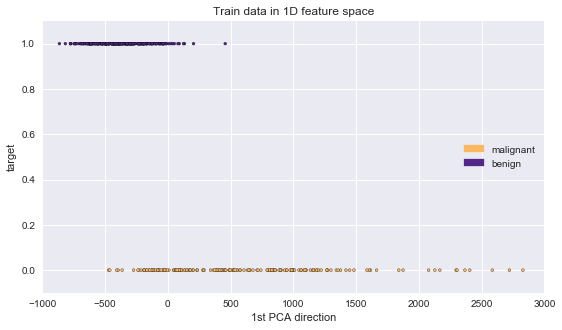

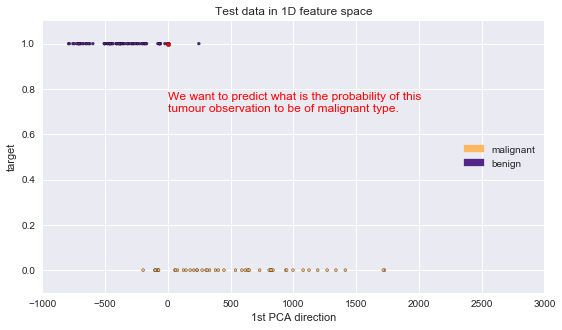

In [6]:
plot_1d(X_train, y_train, title = 'Train data in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,xlims = [-1000, 3000])    

plot_1d(X_test, y_test, title = 'Test data in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]        
       ,xlims = [-1000, 3000]
       ,featured = 1);

### Fitting the model to training data

Next we want to fit the logistic regression model to data. The logistic regression model is similar to ordinary linear regression, but whereas in ordinary linear regression we directly regress the target variable <i>y</i>, in logistic regression we regress the probability of the observation belonging to to certain target class.

To build the logistic regression model, consider the logistic function $\sigma(z)$ having the form

\begin{align*}
\sigma(z) &= \frac{e^{z}}{1+e^{z}}
\end{align*}

Logistic function has an S-like shape and it squeezes any given input value $z$ between 0 and 1. Thus, it can be interpreted as outputting a probability value <i>p</i>, that is 

\begin{align*}
p = \sigma(z)
\end{align*}

Inverse of the logistic function is called <i>logit function</i> and it is defined as

\begin{align*}
logit(p) \equiv \sigma^{-1}(p) = ln \big( \frac{p}{1-p} \big)
\end{align*}

It is easy to check that logit truly is the inverse of logistic function:

\begin{align*}
logit(p) &= ln \big( \frac{\sigma(z)}{1-\sigma(z)} \big) = ln \Big( \frac{\frac{1}{1 + e^{-z}}}{1- \frac{1}{1+e^{-z}}} \Big) \\[4pt]
         &= ln \Big( \frac{\frac{1}{1 + e^{-z}}}{\frac{e^{-z}}{1+e^{-z}}} \Big) = ln \Big( \frac{1}{1+e^{-z}} \ \frac{1+e^{-z}}{e^{-z}} \Big) \\[4pt]
         &= ln \Big( \frac{1}{e^{-z}} \Big) = -ln ( e^{-z} ) \\[4pt]
         &= z
\end{align*}


Recall the linear regression equation

\begin{align*}
y = F(\mathbf{x}) = \mathbf{x} '  \mathbf{\beta}
\end{align*}

Conversly, in logistic regression the term on the left-hand side of the regression equation is the logit :

\begin{align*}
logit(p) = ln \big( \frac{p}{1-p} \big) = \mathbf{x} '  \mathbf{\beta}
\end{align*}

That is, instead of regressin the target variable values as in linear regression, in logistic regression we regress the inverse the logit which is the inverse of the logistic function. As the value of logistic function could be interpreted as probability, logit is the inverse of that probability, also called as <i>log-odds</i>. Equivalenly, in terms of logistic function we have 

\begin{align*}
p = \sigma(\mathbf{x}) = \frac{e^{\mathbf{x}'\beta}}{e^{\mathbf{x}'\beta} + 1}  
\end{align*} 

Following gif/anim exlpains the link function... See Python machine learning book on logistic regression.

Something about estimation of the logistic function...?

Let us now fit the logistic equation to the one-dimensional feature data. What we will get is as S-shaped curve spanning over the x-axis, having values in the range (0,1).

scikit learn intercept -0.10327 and coefficient -0.00837: 


c:\users\ville_000\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  455
Model:                          Logit   Df Residuals:                      453
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Jun 2018   Pseudo R-squ.:                  0.6464
Time:                        19:41:27   Log-Likelihood:                -105.35
converged:                       True   LL-Null:                       -297.99
                                        LLR p-value:                 8.868e-86
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1113      0.209     -0.533      0.594      -0.521       0.298
x1            -0.0084      0.001     -8.982      0.000      -0.010      -0.007
==============================================================================
"""

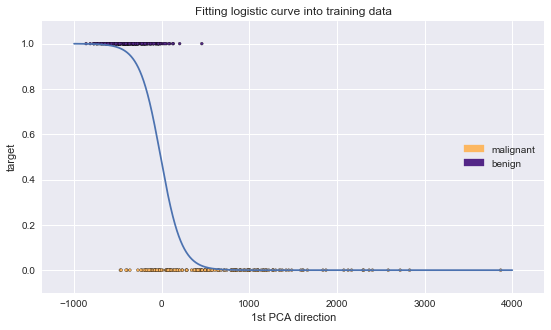

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Pick only one feature
exog = X_train[:,0].reshape((len(X_train),1))

# Scikit learn for accuracy
C = 1e9
model = LogisticRegression(C = C, fit_intercept = True, penalty = 'l1')
model.fit(exog, y_train)
y_pred_1d = model.predict(X_test[:,0].reshape((len(X_test),1)))
y_probs_1d = model.predict_proba(X_test[:,0].reshape((len(X_test),1)))
print('scikit learn intercept {0:.5f} and coefficient {1:.5f}: '.format(model.intercept_[0], model.coef_[0,0]))

# statsmodel for p-values
import statsmodels.api as sm
endog = y_train
exog = sm.add_constant(exog)
logit = sm.Logit(endog, exog)
logit_res = logit.fit(disp=0)
display(logit_res.summary())

# plot
x_ax = np.linspace(-1000.0, 4000.0, num = 5000)
y_ax = np.exp(model.intercept_[0] + model.coef_[0,0] * x_ax) / (1 + np.exp(model.intercept_[0] + model.coef_[0,0] * x_ax))

plot_1d(X_train, y_train, title = 'Fitting logistic curve into training data'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,log_curve = [x_ax, y_ax])    

Model implied probability that for the featured observation target = 1 (benign tumour) can be read off the intersection of vertical and logistic lines, so that the predicted probability of the tumour being malignant is 1 minus this value. In this case our model assigns a probability of 52,1% of the observation being a malignant tumour. 

Since we know that in reality the featured case is a bening tumour, our model currently does not predict the probability too well for the featured observation.

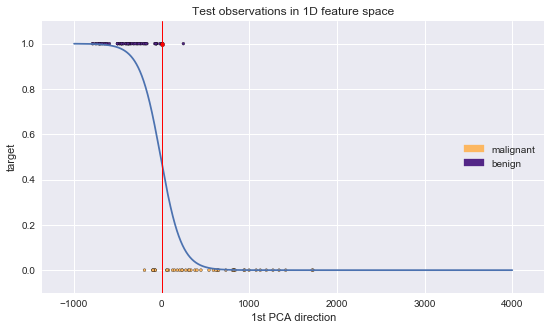

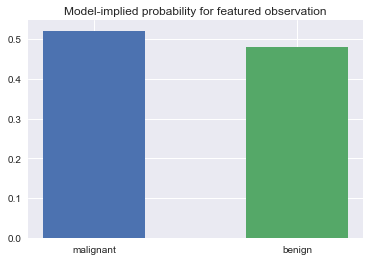

In [8]:
plot_1d(X_test, y_test, title = 'Test observations in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,log_curve = [x_ax, y_ax]
       ,xlims = (-1363.14230778, 4367.17805308)
       ,featured = 2)   

plot_bars(y_probs_1d, 113)    

### Evaluating performance

Combined with a decision rule, we can use the logistic regression as a classifier. Say we decide that our decision rule is to classify observation to class with probability greater than 0.5. In the picture below, observations to the left of the vertical red line have probabiluty above 0.5 to be belonging to benign class, and observations to the right of the curve probability above 0.5 belonging to malignant class.

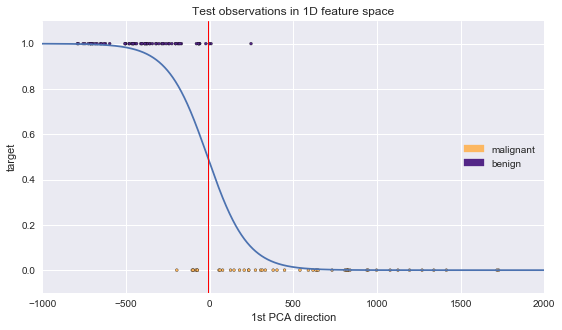

In [9]:
plot_1d(X_test, y_test, title = 'Test observations in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,log_curve = [x_ax, y_ax]
       #,xlims = (-1363.14230778, 4367.17805308)
       ,xlims = (-1000, 2000)        
       ,featured = 4) 

We can use confusion matrix to display how well our classifier performs

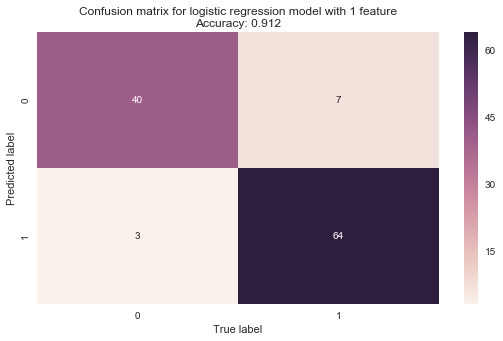

In [10]:
plot_confusion_matrix(y_test, y_pred_1d, title = 'Confusion matrix for logistic regression model with 1 feature')

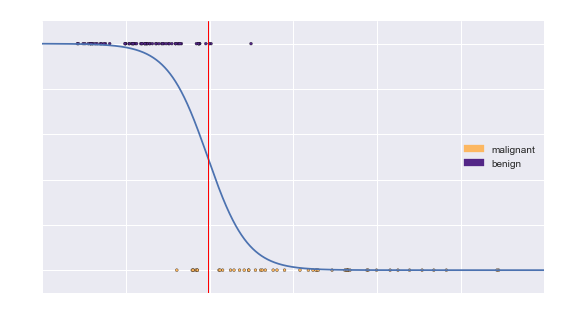

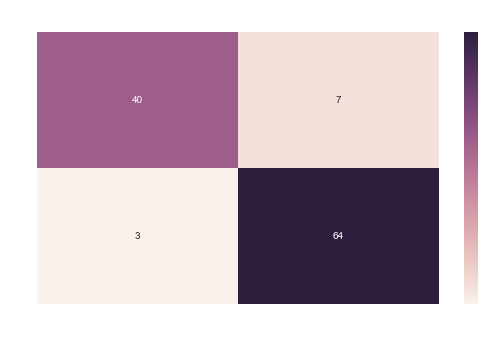

In [11]:
# Save plots for animations
fig = plot_1d(X_test, y_test, title = 'Test observations in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,log_curve = [x_ax, y_ax]
       #,xlims = (-1363.14230778, 4367.17805308)
       ,xlims = (-1000, 2000)        
       ,featured = 4
       ,style = 'animation') 
fig.savefig('animation_1dresult.svg', facecolor=fig.get_facecolor(), format='svg', dpi=1200)

fig = plot_confusion_matrix(y_test, y_pred_1d, title = 'Confusion matrix for logistic regression model with 1 feature', style = 'animation')
fig.savefig('animation_1dconfusionmatrix.svg', facecolor=fig.get_facecolor(), format='svg', dpi=1200)

### Analysis in 2-dimensional feature space

Let us look at the logistic regression with two explanatory variables, namely the 1st and 2nd principal component. First we plot the full data set in the 2-dimesnional feature space. X-axis still exhibits the 1st PC but y-axis is now the 2nd PC. Target variable (having either value 0 or 1) is designated by the color of the blob.

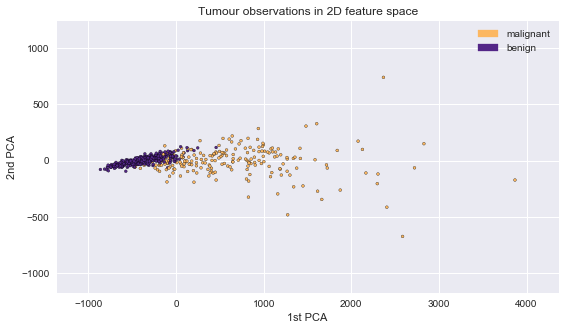

In [12]:
plot_2d(X, y, title = 'Tumour observations in 2D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]);

We divide the data into train and test samples as in 1-dimensional feature space case.

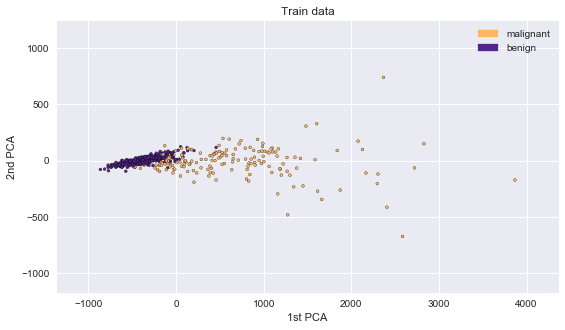

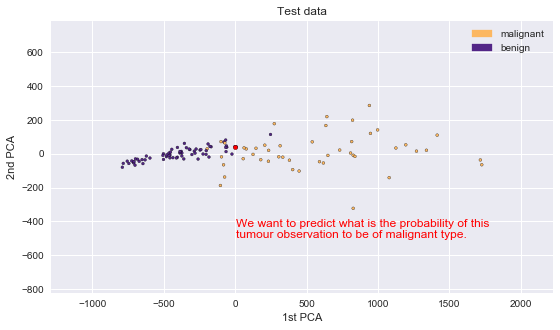

In [13]:
plot_2d(X_train, y_train, title = 'Train data'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]])

plot_2d(X_test, y_test, title = 'Test data'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]], featured = 1);

Let us fit the two feature model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Scikit learn for accuracy
C = 1e9
model = LogisticRegression(C = C)
model.fit(X_train, y_train)
y_pred_2d = model.predict(X_test)
y_probs_2d = model.predict_proba(X_test)
print('scikit learn estimates',model.intercept_, model.coef_)


# statsmodel for p-values
import statsmodels.api as sm
endog = y_train
exog = sm.add_constant(X_train)
logit = sm.Logit(endog, exog)
logit_res = logit.fit()
display(logit_res.summary())


scikit learn estimates [-1.13017797] [[-0.01216135  0.03459493]]
Optimization terminated successfully.
         Current function value: 0.172227
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  455
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Jun 2018   Pseudo R-squ.:                  0.7370
Time:                        19:41:29   Log-Likelihood:                -78.363
converged:                       True   LL-Null:                       -297.99
                                        LLR p-value:                 4.147e-96
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1432      0.338     -3.382      0.001      -1.806      -0.481
x1            -0.0122      0.001     -8.597      0.000      -0.015      -0.009
x2             0.0347      0.006      5.972      0.000       0.023       0.046
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Draw a smilar figure with probability as above but now in two-dimensional space. AS we can see, the model now implies that the probability of observation is benign is somwhat higher than the probability for the observation being malignant. In this terms the model built with two features works better than the model with just one feature.

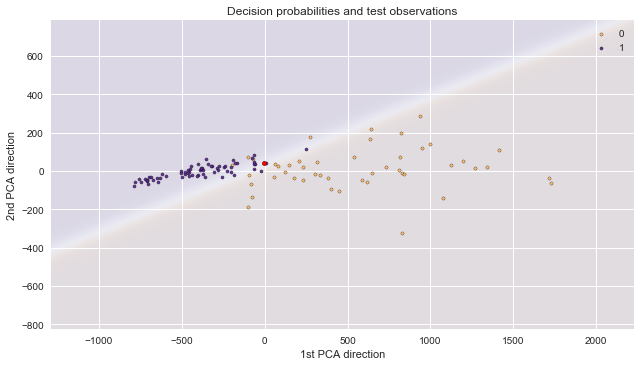

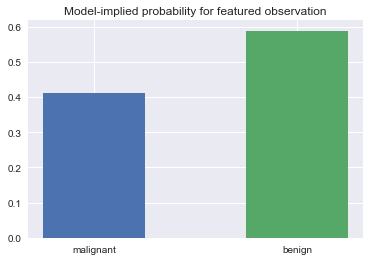

In [15]:
# plot
plot_bin_decision_probs(X_test, y_test, model
                        ,title = 'Decision probabilities and test observations'
                        ,mesh_step_size = 1, correction = 500
                        ,featured = 1)

plot_bars(y_probs_2d, 113)

We can again use the 0.5 probability decision rule to use the trained logistic regression model as classifier. Whereas in the 1-feature case the decision boundary was a vertical line, here it is an affine line in the 2 dimensional space. AS we can see, the featured observation is classified as benign which is what we would want from our model.

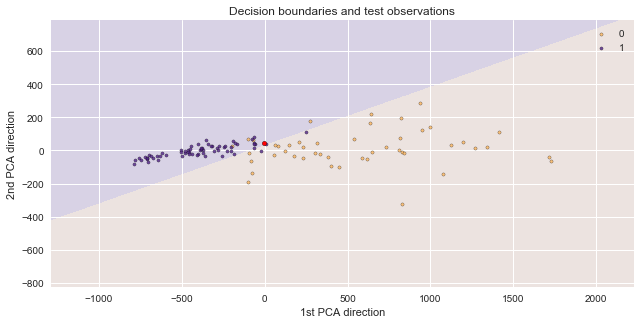

In [16]:
plot_decision_boundaries(X_test, y_test, model, title = 'Decision boundaries and test observations', mesh_step_size = 1, correction = 500, featured = 1)

Looking at the confusion matrix, we can see that our model performs overall better: Accuracy has increase to 0.947 as the amount of false positives has decreased by 3 and false negatives by one.

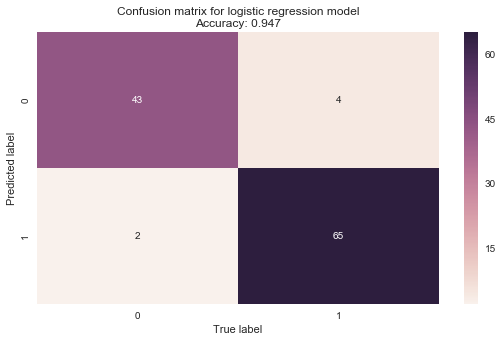

In [17]:
plot_confusion_matrix(y_test, y_pred_2d, title = 'Confusion matrix for logistic regression model')

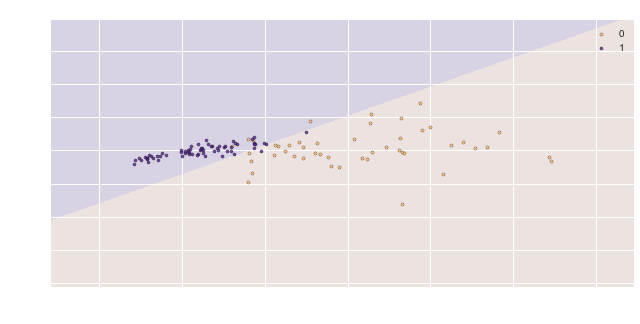

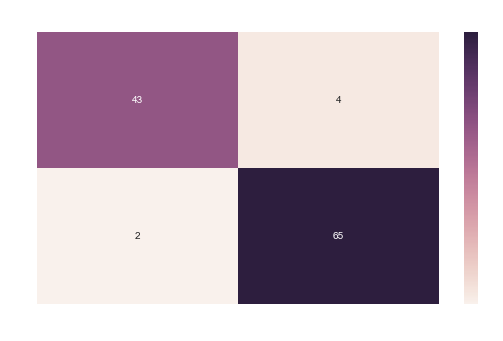

In [20]:
# Save plots for animations
fig = plot_decision_boundaries(X_test, y_test, model, title = 'Decision boundaries and test observations', mesh_step_size = 1, correction = 500, featured = 0, style = 'animation') 
fig.savefig('animation_2dresult.svg', facecolor=fig.get_facecolor(), format='svg', dpi=300)

fig = plot_confusion_matrix(y_test, y_pred_2d, title = 'Confusion matrix for logistic regression model with 2 features', style = 'animation')
fig.savefig('animation_2dconfusionmatrix.svg', facecolor=fig.get_facecolor(), format='svg', dpi=1200)

In [19]:
# Find the featured observation
gg = pd.DataFrame(X_test)
gg[(gg.iloc[:,0] < 10) & (gg.iloc[:,0] > -50) ]

,0,1
70,-23.014143,-1.914592
92,8.282177,40.248907
113,-2.306757,42.173155


## Conclusion

Conclusion here